In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm
import numpy as np
import time
import glob
from pyquaternion import Quaternion
from scipy.spatial.transform import Rotation as Rot
import seaborn as sns
sns.set_theme()
tf.config.list_physical_devices('GPU')

1 Physical GPUs, 1 Logical GPUs


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from collections import defaultdict

def get_R(angles):
    ''' Get rotation matrix from three rotation angles (radians). right-handed.
    Args:
        angles: [3,]. x, y, z angles
    Returns:
        R: [3, 3]. rotation matrix.
    '''
    x, y, z = angles.astype(np.float32)
    # x
    Rx = np.array([[1, 0, 0],
                   [0, np.cos(x), -np.sin(x)],
                   [0, np.sin(x), np.cos(x)]])
    # y
    Ry = np.array([[np.cos(y), 0, np.sin(y)],
                   [0, 1, 0],
                   [-np.sin(y), 0, np.cos(y)]])
    # z
    Rz = np.array([[np.cos(z), -np.sin(z), 0],
                   [np.sin(z), np.cos(z), 0],
                   [0, 0, 1]])

    R = Rz.dot(Ry.dot(Rx))
    return R

INIT_AXES = np.array([[1,0,0], [0,1,0], [0,0,1]]).astype(np.float32)

def get_data(min_angle_rad=-np.pi, max_angle_rad=np.pi, nb_examples=30000, split=0.1):
    data = defaultdict(lambda: [])
    for i in tqdm(range(nb_examples)):
        angles = np.random.uniform(min_angle_rad, max_angle_rad, size=3)
        R = get_R(angles)
        q = Quaternion(matrix=R, rtol=1e-05, atol=1e-05).elements.astype(np.float32)
        data['R'].append(R)
        data['angles'].append(angles)
        # full quaternion
        data['q'].append(q)
        # quaternion constraint to one hemisphere
        data['qh'].append(-q if q[0] < 0 else q)
        data['rotated_axes'].append(R.dot(INIT_AXES.T).T)
    for key in data.keys():
        data[key] = np.array(data[key])
    return data

In [8]:
class NP_Q:
    
    @classmethod
    def norm(cls, q):
        return np.sqrt(np.dot(q,q))
    
    @classmethod
    def mult(cls, p,q):
        s = p[0]*q[0] - np.dot(p[1:], q[1:])
        v = p[0]*q[1:] + q[0]*p[1:] + np.cross(p[1:], q[1:])
        return np.append([s], v)
    
    @classmethod
    def conjugate(cls, q):
        return np.array([q[0], -q[1], -q[2], -q[3]])
    
    @classmethod
    def inverse(cls, q):
        return cls.conjugate(q) / np.dot(q,q)
    
    @classmethod
    def log(cls, q):
        v = q[1:]
        a = q[0]
        x = a/cls.norm(q)
        real_part = np.log(cls.norm(q))
        vec_part = v/np.linalg.norm(v, axis=-1) * np.arccos(x)
        return np.append([real_part], vec_part)
    
    @classmethod
    def geodesic_dist(cls, q1, q2):
        x = cls.mult(cls.inverse(q1), q2)
        return cls.norm(cls.log(x))
    
    @classmethod
    def angle_dist(cls, q1,q2):
        x = 2*(np.dot(q1,q2))**2 - 1
        return np.arccos(x) / np.pi * 180

class TF_Q:
    
    @classmethod
    def conjugate(cls, q):
        mult = tf.constant(np.array([1,-1,-1,-1])[np.newaxis], dtype=np.float32)
        return q*mult
    
    @classmethod
    def inverse(cls, q):
        return cls.conjugate(q) / tf.reduce_sum(q*q, axis=-1, keepdims=True)
    
    @classmethod
    def log(cls, q):
        v = q[:, 1:]
        a = q[:, :1]
        q_norm = tf.norm(q, axis=-1, keepdims=True)
        x = a / q_norm
        eps = np.finfo(np.float32).eps * 8.0
        x *= (1.0 - eps)
        vec_part = tf.nn.l2_normalize(v, axis=-1) * tf.math.acos(x)
        real_part = tf.math.log(q_norm)
        return tf.concat([real_part, vec_part], axis=-1)
    
    @classmethod
    def mult(cls, quaternion1, quaternion2):
        w1, x1, y1, z1 = tf.unstack(quaternion1, axis=-1)
        w2, x2, y2, z2 = tf.unstack(quaternion2, axis=-1)
        x = x1 * w2 + y1 * z2 - z1 * y2 + w1 * x2
        y = -x1 * z2 + y1 * w2 + z1 * x2 + w1 * y2
        z = x1 * y2 - y1 * x2 + z1 * w2 + w1 * z2
        w = -x1 * x2 - y1 * y2 - z1 * z2 + w1 * w2
        return tf.stack((w, x, y, z), axis=-1)
    
    @classmethod
    def geodesic_dist(cls, q1, q2):
        x = cls.mult(cls.inverse(q1), q2)
        x = tf.norm(cls.log(x), axis=-1)
        return x
    
    @classmethod
    def angle_dist(cls, q1, q2):
        x = tf.reduce_sum(q1*q2, axis=-1)
        eps = np.finfo(np.float32).eps * 8.0
        x *= (1.0 - eps)
        x = 2*tf.math.acos(x)
        return tf.reduce_mean(x)

    @classmethod
    def rotate_by_q(cls, point, quaternion):
        point = tf.pad(tensor=point, paddings=[[0,0], [1,0]], mode="CONSTANT")
        point = cls.mult(quaternion, point)
        point = cls.mult(point, cls.conjugate(quaternion))
        _, xyz = tf.split(point, (1, 3), axis=-1)
        return xyz
        
    
def quat_antipodal_loss(y_true, y_pred):
    dist1 = tf.reduce_mean(tf.abs(y_true-y_pred), axis=-1)
    dist2 = tf.reduce_mean(tf.abs(y_true+y_pred), axis=-1)
    loss = tf.where(dist1<dist2, dist1, dist2)
    return tf.reduce_mean(loss)


def euler_angles_loss(y_true, y_pred):
    dist1 = tf.abs(y_true - y_pred)
    dist2 = tf.abs(2*np.pi + y_true - y_pred)
    dist3 = tf.abs(-2*np.pi + y_true - y_pred)
    loss = tf.where(dist1<dist2, dist1, dist2)
    loss = tf.where(loss<dist3, loss, dist3)
    return tf.reduce_mean(loss)


def mean_angle_btw_vectors(v1, v2):
    dot_product = tf.reduce_sum(v1*v2, axis=-1)
    cos_a = dot_product / (tf.norm(v1, axis=-1) * tf.norm(v2, axis=-1))
    eps = 1e-8
    cos_a = tf.clip_by_value(cos_a, -1 + eps, 1 - eps)
    angle_dist = tf.math.acos(cos_a) / np.pi * 180.0
    return tf.reduce_mean(angle_dist)


class QuatNet(tf.keras.Model):

    def __init__(self):
        super(QuatNet, self).__init__()
        
        self.block = tf.keras.Sequential([
              tf.keras.layers.Dense(128, activation='relu'),
              tf.keras.layers.Dense(64, activation='relu'),
              tf.keras.layers.Dense(4, activation=None)
          ])
    
    def get_rotated(self, q_pred):
        q_pred = tf.nn.l2_normalize(q_pred, axis=-1)
        init_v = tf.constant(INIT_AXES[np.newaxis], dtype=tf.float32)
        init_v = tf.tile(init_v, multiples=[tf.shape(q_pred)[0], 1, 1])
        x_axis = TF_Q.rotate_by_q(init_v[:,0], q_pred)
        y_axis = TF_Q.rotate_by_q(init_v[:,1], q_pred)
        z_axis = TF_Q.rotate_by_q(init_v[:,2], q_pred)
        y_pred = tf.stack([x_axis, y_axis, z_axis], axis=1)
        return y_pred
        
    def call(self, inputs, training=False):
        x = tf.reshape(inputs, (-1, 9))
        x = self.block(x)
        x = tf.nn.l2_normalize(x, axis=-1)
        self.add_metric(mean_angle_btw_vectors(inputs, self.get_rotated(x)), 
                        name='mean_angular_distance', aggregation='mean')
        return x

    
class EulerNet(tf.keras.Model):

    def __init__(self):
        super(EulerNet, self).__init__()
        
        self.block = tf.keras.Sequential([
              tf.keras.layers.Dense(128, activation='relu'),
              tf.keras.layers.Dense(64, activation='relu'),
              tf.keras.layers.Dense(3, activation=None)
          ])
        
    def angle2matrix(self, angles):
        ''' get rotation matrix from three rotation angles (radians). right-handed.
        Args:
            angles: [3,]. x, y, z angles
            x: pitch. positive for looking down.
            y: yaw. positive for looking left.
            z: roll. positive for tilting head right.
        Returns:
            R: [3, 3]. rotation matrix.
        '''
        x, y, z = angles[0], angles[1], angles[2]
        # x
   
        Rx = tf.stack([1.0, 0.0, 0.0,
               0.0, tf.math.cos(x), -tf.math.sin(x),
               0.0, tf.math.sin(x), tf.math.cos(x)])
        Rx = tf.reshape(Rx, (3,3))
        
        # y
        Ry = tf.stack([tf.math.cos(y), 0, tf.math.sin(y),
                       0, 1, 0,
                       -tf.math.sin(y), 0, tf.math.cos(y)])
        Ry = tf.reshape(Ry, (3,3))
        
        # z
        Rz = tf.stack([tf.math.cos(z), -tf.math.sin(z), 0,
                       tf.math.sin(z), tf.math.cos(z), 0,
                       0, 0, 1])
        Rz = tf.reshape(Rz, (3,3))
    
        R = tf.matmul(Rz,tf.matmul(Ry, Rx))
        return R
    
    
    def get_rotated(self, pred_angles):
        init_v = tf.constant(INIT_AXES, dtype=tf.float32)
        Rs = tf.map_fn(self.angle2matrix, pred_angles)
        y_pred = tf.transpose(tf.matmul(Rs, tf.transpose(init_v)), [0, 2, 1])
        return y_pred


    def call(self, inputs, training=False):
        x = tf.reshape(inputs, (-1, 9))
        x = self.block(x)
        self.add_metric(mean_angle_btw_vectors(inputs, self.get_rotated(x)), 
                        name='mean_angular_distance', aggregation='mean')
        return x

    
class Net6D(tf.keras.Model):

    def __init__(self, ):
        super(Net6D, self).__init__()
        
        self.block = tf.keras.Sequential([
              tf.keras.layers.Dense(128, activation='relu'),
              tf.keras.layers.Dense(64, activation='relu'),
              tf.keras.layers.Dense(6, activation=None)
        ])
        
    def dot(self, a, b):
        return tf.reduce_sum(a*b, axis=-1, keepdims=True)
    
    def get_rotation_matrix(self, x):
        c1 = x[:,:3]
        c2 = x[:,3:]
        c3 = tf.linalg.cross(c1, c2)
        return tf.stack([c1,c2,c3], axis=2)
        
    def get_rotated(self, repr_6d):
        init_v = tf.constant(INIT_AXES, dtype=tf.float32)
        Rs = self.get_rotation_matrix(repr_6d)
        y_pred = tf.transpose(tf.matmul(Rs, tf.transpose(init_v)), [0, 2, 1])
        return y_pred
        
    def call(self, inputs, training=False):
        x = tf.reshape(inputs, (-1, 9))
        x = self.block(x)
        c1 = tf.nn.l2_normalize(x[:, :3], axis=-1)
        c2 = tf.nn.l2_normalize(x[:, 3:] - self.dot(c1,x[:, 3:])*c1, axis=-1)
        x = tf.concat([c1,c2], axis=-1)
        self.add_metric(mean_angle_btw_vectors(inputs, self.get_rotated(x)), 
                        name='mean_angular_distance', aggregation='mean')
        return x


In [4]:
import matplotlib.ticker as mticker
from scipy.ndimage import gaussian_filter1d


def plot_histories(histories, title='Validation performance', 
                   legends = ['Euler angles', 'Quaternions', '6D representation'],
                   colors = ['red', 'green', 'blue'], ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,5))
    else:
        fig=None
        
    for idx, hist in enumerate(histories):
        metrics = hist.history['val_mean_angular_distance']
        metrics = gaussian_filter1d(metrics, 2)
        ax.plot(range(1, len(hist.epoch)+1), metrics, color=colors[idx])
        
    ax.set(xlabel='Epoch', ylabel='Mean angle error (deg)',
           title=title)
    
    yticks = ax.get_yticks().tolist()
    ax.yaxis.set_major_locator(mticker.FixedLocator(yticks))
    ylabels = ['%.1f°' % y  for y in yticks]
    _ = ax.set_yticklabels(ylabels)
    _ = ax.set_xticks(range(1, len(hist.epoch)+1, 2))
    ax.legend(legends)
    return fig

def train_models(data, nb_epochs, verbose=0, batch_size=64):
    euler_net = EulerNet()
    euler_net.compile(optimizer='adam', loss = euler_angles_loss)
    print('Training EulerNet')
    euler_hist = euler_net.fit(x=data['rotated_axes'], y=data['angles'], batch_size=batch_size, 
                               validation_split=0.2, epochs=nb_epochs, verbose=verbose)
    
    quat_net = QuatNet()
    quat_net.compile(optimizer='adam', loss = quat_antipodal_loss)
    print('Training QuatNet')
    quat_hist = quat_net.fit(x=data['rotated_axes'], y=data['q'], batch_size=batch_size, 
                             validation_split=0.2, epochs=nb_epochs, verbose=verbose)
    
    repr6D = data['R'][:, :, :2].transpose(0,2,1).reshape(-1, 6)
    net6D = Net6D()
    net6D.compile(optimizer='adam', loss = 'mae')
    print('Training Repr6DNet')
    history_6d = net6D.fit(x=data['rotated_axes'], y=repr6D, batch_size=batch_size, 
                           validation_split=0.2, epochs=nb_epochs, verbose=verbose)
    
    return [euler_hist, quat_hist, history_6d]

In [249]:
data = get_data(-np.pi/4, np.pi/4, 30000)
histories = train_models(data, nb_epochs=20, verbose=0, batch_size=64)

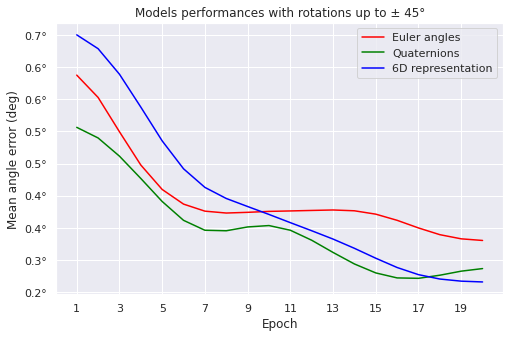

In [285]:
fig1 = plot_histories(histories, 'Models performances with rotations up to ± 45°')
fig1.savefig('assets/plot45.png')

In [248]:
data = get_data(-np.pi/2, np.pi/2, 30000)
histories2 = train_models(data, nb_epochs=20, verbose=0, batch_size=64)

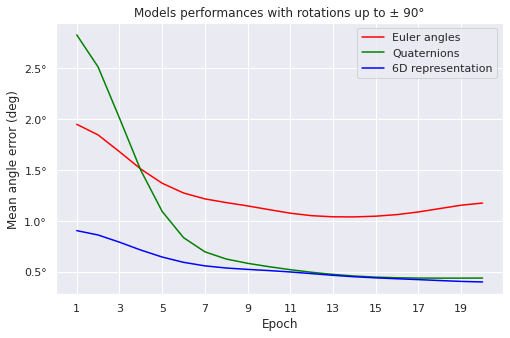

In [271]:
fig2 = plot_histories(histories2, 'Models performances with rotations up to ± 90°')
fig2.savefig('assets/plot90.png')

In [241]:
data = get_data(-np.pi, np.pi, 30000)
histories3 = train_models(data, nb_epochs=20, verbose=0, batch_size=64)


Training EulerNet
Training QuatNet
Training Repr6DNet


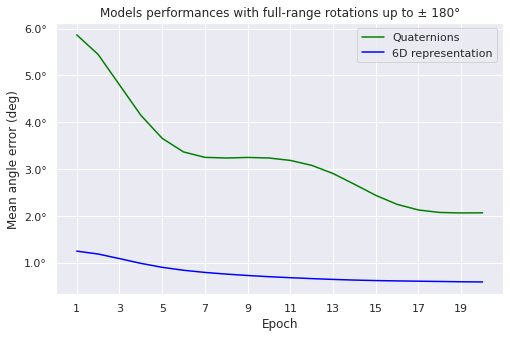

In [272]:
fig3 = plot_histories(histories3[1:], 'Models performances with full-range rotations up to ± 180°',
                      legends = ['Quaternions', '6D representation'],
                      colors= ['green', 'blue'])
fig3.savefig('assets/plot180_1.png')

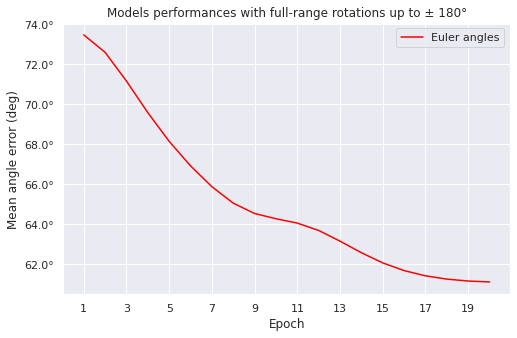

In [273]:
fig4 = plot_histories(histories3[:1], 'Models performances with full-range rotations up to ± 180°',
                      legends = ['Euler angles'],
                      colors= ['red'])
fig4.savefig('assets/plot180_2.png')

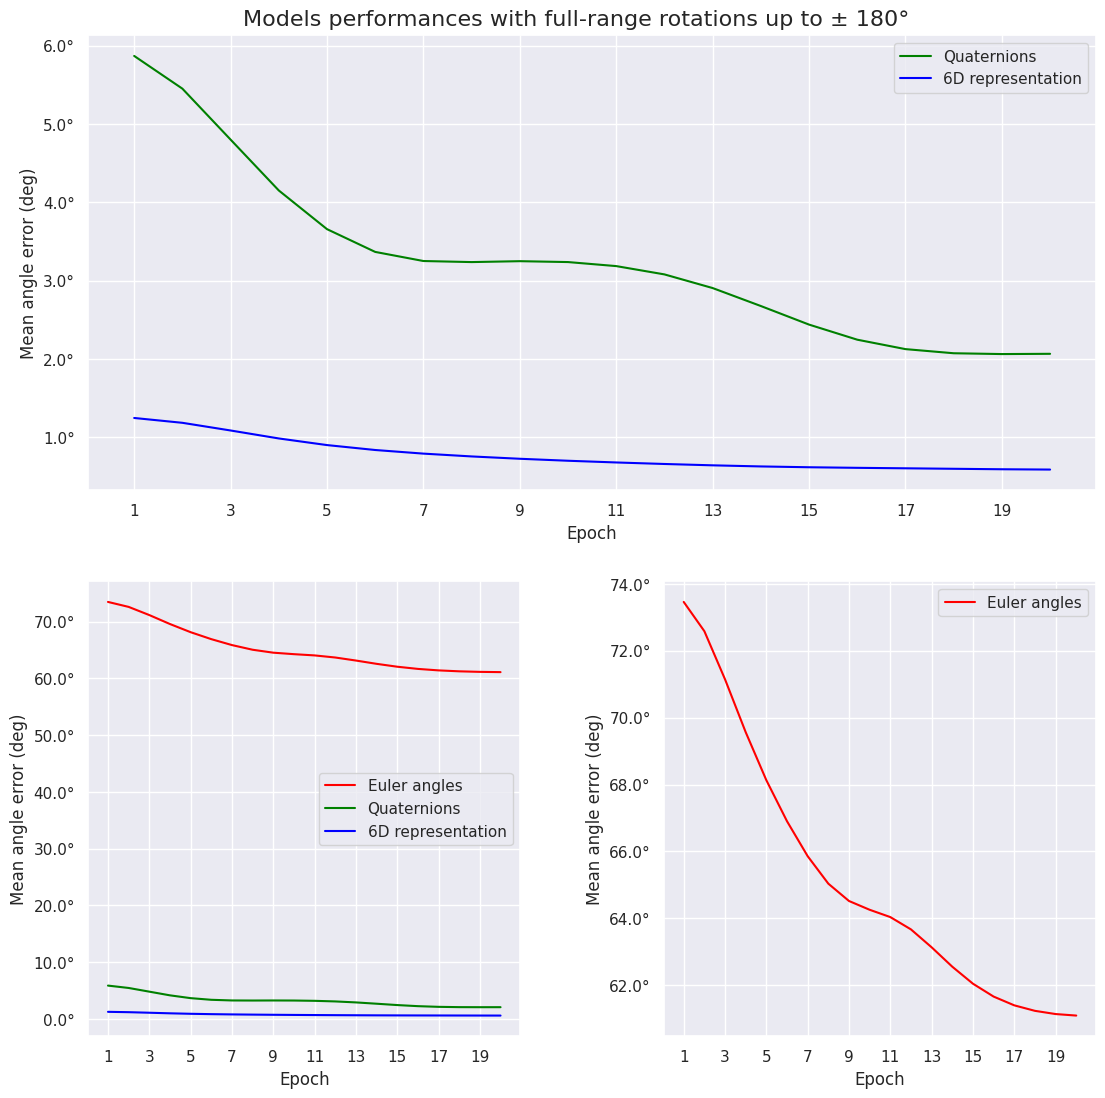

In [353]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=1.0)

plt.figure(figsize=(13,13))
ax = plt.subplot(gs[0, :])

fig3 = plot_histories(histories3[1:], '',
                      legends = ['Quaternions', '6D representation'],
                      colors= ['green', 'blue'], ax=ax)



ax = plt.subplot(gs[1, :2])
plot_histories(histories3, 
                      '',
                      ax = ax)

ax = plt.subplot(gs[1, 2:])
plot_histories(histories3[:1], '',
                      legends = ['Euler angles'],
                      colors= ['red'],
                      ax = ax)

_= plt.suptitle('Models performances with full-range rotations up to ± 180°', 
                fontsize=16, y=0.9)

plt.savefig('assets/plot180.png')